In [ ]:
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#  Copyright 2021-  QuOCS Team
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [34]:
import matplotlib.pyplot as plt
import os, sys

# Ising model optimization

### The model

Description

$H(t) = J \sum_j \sigma_j^z \sigma_{j+1}^z \; + g \sum_j \sigma_j^z \sigma_{j+2}^z \; + u(t) \sum_j \sigma_j^x \;$

## dCRAB Optimization

In [55]:
from quocslib.optimalcontrolproblems.OneQubitProblem import OneQubit
from quocslib.handleexit.HandleExit import HandleExit
from quocslib.utils.dynamicimport import dynamic_import
from quocslib.utils.inputoutput import readjson
from quocslib.communication.AllInOneCommunication import AllInOneCommunication
from quocslib.utils.BestDump import BestDump
from IsingModel.dCRAB.AlastairProblem import AlastairFoM

### Define the Model

In [58]:
from quocslib.utils.AbstractFom import AbstractFom
import numpy as np
from IsingModel.evolution import *

class IsingModel(AbstractFom):
    """A figure of merit class for optimization of the problem defined by Alastair
        via http://arxiv.org/abs/2110.06187"""

    def __init__(self, args_dict:dict = None):
        """ Initialize the dynamics variables"""
        if args_dict is None:
            args_dict = {}

        self.n_qubits = args_dict.setdefault("n_qubits", 5)
        self.J = args_dict.setdefault("J", 1)
        self.g = args_dict.setdefault("g", 2)

        self.H0 = get_static_hamiltonian(self.n_qubits, self.J, self.g)
        self.H_t = get_control_hamiltonian(self.n_qubits)
        self.rho0 = get_initial_state(self.n_qubits)
        self.rhoT = get_final_state(self.n_qubits)

        self.N_slices = args_dict.setdefault("N_slices", 100)
        self.T = args_dict.setdefault("T", 1.0)
        self.dt = self.T / self.N_slices


    def get_FoM(self, pulses: list = [], parameters: list = [], timegrids: list = []) -> dict:
        """ Compute the dynamics and the figure of merit """
        drive = pulses[0].reshape(1, len(pulses[0]))
        # allocate a storage array
        prop_store = [np.zeros_like(self.H0) for i in range(self.N_slices)]
        pw_evolution(prop_store, drive, self.H0, [self.H_t], self.N_slices, self.dt)

        # Compute the final propagator
        Ufinal = functools.reduce(lambda a, b: a @ b, prop_store)
        # evolve initial state
        rhoev = Ufinal @ self.rho0 @ Ufinal.T.conj()
        # Calculate the fidelity    
        fidelity = fidelity_funct(rhoev.T, self.rhoT)
        
        return {"FoM": -fidelity}

### Define the Configuration dictionary

#### Name

In [ ]:
optimization_dictionary = {"optimization_client_name": "IsingModelWorkshop"} 

#### The algorithm

The name

In [ ]:
optimization_dictionary["opti_algorithm_module"] = "quocslib.optimalalgorithms.dCRABAlgorithm"
optimization_dictionary["opti_algorithm_class"] = "DCrabAlgorithm"

The settings

In [ ]:
optimization_dictionary["algorithm_settings"] = {
        "super_iteration_number": 3,
        "maximum_function_evaluations_number": 1000
    }

#### Updating algorithm and Stopping criteria

In [ ]:
optimization_dictionary["dsm_settings"] = {
        "general_settings": {
            "dsm_name": "nelder_mead",
            "is_adaptive": true
        },
        "stopping_criteria": {
            "xatol": 1e-14,
            "frtol": 1e-3
        }
    }

#### The Controls

In [ ]:
pulse_x = {"pulse_name": "Pulse1",
            "upper_limit": 1000.0,
            "lower_limit": -1000.0,
            "amplitude_variation": 10.0}

#### Initial guess

In [ ]:
pulse_x["initial_guess"] = {
                "function_type": "lambda_function",
                "lambda_function": "lambda t: 0.0 + 0.0*t"
            }

#### Scaling Function


In [ ]:
pulse_x["scaling_function"] = {
                "function_type": "lambda_function",
                "lambda_function": "lambda t: 1.0 + 0.0*t"
            }

### Customize a basis

In [59]:
from quocslib.pulses.basis.ChoppedBasis import ChoppedBasis
from quocslib.tools.randomgenerator import RandomNumberGenerator

class FourierWorkshop(ChoppedBasis):
    amplitude_variation: float
    optimized_control_parameters: np.ndarray
    optimized_super_parameters: np.ndarray
    time_grid: np.ndarray

    def __init__(self, map_index: int, pulse_dictionary: dict, rng: RandomNumberGenerator = None):
        """

        :param int map_index: Index number to use to get the control parameters for the Fourier basis
        :param dict pulse_dictionary: The dictionary of the pulse defined here. Only the basis dictionary is used btw
        """
        basis_dict = pulse_dictionary["basis"]
        # Frequencies number i.e. the basis vector number in the pulse parametrization
        self.super_parameter_number = basis_dict.setdefault("basis_vector_number", 1)
        # Number of control parameters to be optimized
        self.control_parameters_number = 2 * self.super_parameter_number
        # Constructor of the parent class, i.e. Chopped Basis
        super().__init__(map_index=map_index, rng=rng, **pulse_dictionary)
        # Define scale and offset coefficients
        self.scale_coefficients = self.amplitude_variation / np.sqrt(2) * np.ones((self.control_parameters_number,))
        self.offset_coefficients = np.zeros((self.control_parameters_number,))

    def _get_shaped_pulse(self) -> np.array:
        """ Definition of the pulse parametrization. It is called at every function evaluation to build the pulse """
        # Pulse definition
        pulse = np.zeros(self.bins_number)
        # Final time definition
        final_time = self.final_time
        # Pulse creation
        xx = self.optimized_control_parameters
        w = self.super_parameter_distribution_obj.w
        t = self.time_grid
        for ii in range(self.super_parameter_number):
            pulse += xx[2*ii] * np.sin(2 * np.pi * w[ii] * t / final_time) + \
                     xx[2*ii + 1] * np.cos(2 * np.pi * w[ii] * t / final_time)
        return pulse

In [ ]:
pulse_x["basis"] = {
                "basis_name": "FourierWorkshop",
                "basis_attribute": FourierWorkshop,
                "basis_vector_number": 5,
                "random_super_parameter_distribution": {
                    "distribution_name": "Uniform",
                    "distribution_class": "Uniform",
                    "distribution_module": "quocslib.pulses.superparameter.Uniform",
                    "lower_limit": 0.01,
                    "upper_limit": 5.0
                }
            }

#### The times

In [ ]:
pulse_x["time_name"] = "time1"

In [ ]:
time1 = {"time_name": "time1",
        "initial_value": 1.0 }

Insert the controls in the optimization dictionary

In [ ]:
optimization_dictionary["pulses"] = [pulse_x]
optimization_dictionary["parameters"] = []
optimization_dictionary["times"] = []

### Create the communication object

In [38]:
interface_job_name = optimization_dictionary["optimization_client_name"]

communication_obj = AllInOneCommunication(interface_job_name=interface_job_name,
                                          fom_obj=IsingModel(args_dict), 
                                          handle_exit_obj=HandleExit(),
                                          dump_attribute=BestDump)

### Create the optimizer

In [43]:
from quocslib.optimalalgorithms.dCRABAlgorithm import DCrabAlgorithm
optimizer_obj = DCrabAlgorithm(optimization_dict=optimization_dictionary,
                                        communication_obj=communication_obj)
t1 = time.time()

print("The optimizer was initialized successfully")
optimizer_obj.begin()
print("The optimizer started successfully")
optimizer_obj.run()
print("The optimizer ran successfully")
optimizer_obj.end()
print("The optimizer finished successfully")

t2 = time.time()

dsm_name is used direct search methods. This option is deprecated. Use 
dsm_algorithm_module: quocslib.freegradients.NelderMead
dsm_algorithm_class: NelderMead
{'xatol': 1e-14, 'frtol': 0.001}
Testing shaping option list mode
The optimizer was initialized successfully
INFO     oc_logger    QuOCS version number: 0.0.a7
The optimizer started successfully
INFO     oc_logger    Found a record. Previous fom: 10000000000.0, new best fom : -0.0
INFO     oc_logger    Function evaluation number: 1, FoM: -0.0
INFO     oc_logger    Found a record. Previous fom: -0.0, new best fom : -3.110808231862721e-08
INFO     oc_logger    Function evaluation number: 2, FoM: -3.110808231862721e-08
INFO     oc_logger    Found a record. Previous fom: -3.110808231862721e-08, new best fom : -0.016264949096312372
INFO     oc_logger    Function evaluation number: 3, FoM: -0.016264949096312372
INFO     oc_logger    Function evaluation number: 4, FoM: -0.0011368356993034384
INFO     oc_logger    Function evaluation nu

INFO     oc_logger    Found a record. Previous fom: -0.559034255840459, new best fom : -0.7343752518720913
INFO     oc_logger    Function evaluation number: 80, FoM: -0.7343752518720913
INFO     oc_logger    Found a record. Previous fom: -0.7343752518720913, new best fom : -0.79781046822842
INFO     oc_logger    Function evaluation number: 81, FoM: -0.79781046822842
INFO     oc_logger    Function evaluation number: 82, FoM: -0.6016068065757273
INFO     oc_logger    Function evaluation number: 83, FoM: -0.0965994771165983
INFO     oc_logger    Function evaluation number: 84, FoM: -0.1771165424750686
INFO     oc_logger    Found a record. Previous fom: -0.79781046822842, new best fom : -0.9504692086364546
INFO     oc_logger    Function evaluation number: 85, FoM: -0.9504692086364546
INFO     oc_logger    Function evaluation number: 86, FoM: -0.9449742162084329
INFO     oc_logger    Found a record. Previous fom: -0.9504692086364546, new best fom : -0.9563575769870222
INFO     oc_logger    

INFO     oc_logger    Function evaluation number: 173, FoM: -0.9601477541689525
INFO     oc_logger    Function evaluation number: 174, FoM: -0.9507076883785567
INFO     oc_logger    Function evaluation number: 175, FoM: -0.9763761873457482
INFO     oc_logger    Function evaluation number: 176, FoM: -0.9622927259783634
INFO     oc_logger    Function evaluation number: 177, FoM: -0.9754113476206703
INFO     oc_logger    Function evaluation number: 178, FoM: -0.9401478980351288
INFO     oc_logger    Function evaluation number: 179, FoM: -0.9772291750031927
INFO     oc_logger    Function evaluation number: 180, FoM: -0.9672940976957365
INFO     oc_logger    Function evaluation number: 181, FoM: -0.9773904355451506
INFO     oc_logger    Function evaluation number: 182, FoM: -0.968366258659921
INFO     oc_logger    Function evaluation number: 183, FoM: -0.9789445217866043
INFO     oc_logger    Function evaluation number: 184, FoM: -0.96704199837417
INFO     oc_logger    Found a record. Previ

INFO     oc_logger    Found a record. Previous fom: -0.9925147150577829, new best fom : -0.9929984603014959
INFO     oc_logger    Function evaluation number: 258, FoM: -0.9929984603014959
INFO     oc_logger    Function evaluation number: 259, FoM: -0.9926246784543389
INFO     oc_logger    Function evaluation number: 260, FoM: -0.9914897611627508
INFO     oc_logger    Function evaluation number: 261, FoM: -0.9892752577317362
INFO     oc_logger    Function evaluation number: 262, FoM: -0.9920141460650065
INFO     oc_logger    Found a record. Previous fom: -0.9929984603014959, new best fom : -0.9931897328162682
INFO     oc_logger    Function evaluation number: 263, FoM: -0.9931897328162682
INFO     oc_logger    Function evaluation number: 264, FoM: -0.9926966611591974
INFO     oc_logger    Function evaluation number: 265, FoM: -0.9910287287614431
INFO     oc_logger    Function evaluation number: 266, FoM: -0.9930505020765917
INFO     oc_logger    Function evaluation number: 267, FoM: -0.9

INFO     oc_logger    Function evaluation number: 353, FoM: -0.5336058677095743
INFO     oc_logger    Function evaluation number: 354, FoM: -0.7951267526404514
INFO     oc_logger    Function evaluation number: 355, FoM: -0.5572532443512507
INFO     oc_logger    Function evaluation number: 356, FoM: -0.822378193177415
INFO     oc_logger    Function evaluation number: 357, FoM: -0.5715257289854645
INFO     oc_logger    Function evaluation number: 358, FoM: -0.8310233811863619
INFO     oc_logger    Function evaluation number: 359, FoM: -0.3866527052337997
INFO     oc_logger    Function evaluation number: 360, FoM: -0.73925278885016
INFO     oc_logger    Function evaluation number: 361, FoM: -0.5591693931735361
INFO     oc_logger    Function evaluation number: 362, FoM: -0.8334506858536428
INFO     oc_logger    Function evaluation number: 363, FoM: -0.498608955627575
INFO     oc_logger    Function evaluation number: 364, FoM: -0.8359927370465556
INFO     oc_logger    Function evaluation nu

INFO     oc_logger    Function evaluation number: 456, FoM: -0.9860948170550081
INFO     oc_logger    Function evaluation number: 457, FoM: -0.9762856109205676
INFO     oc_logger    Function evaluation number: 458, FoM: -0.9870381213733654
INFO     oc_logger    Function evaluation number: 459, FoM: -0.9749018164138323
INFO     oc_logger    Function evaluation number: 460, FoM: -0.9873281261845186
INFO     oc_logger    Function evaluation number: 461, FoM: -0.9872351345695092
INFO     oc_logger    Function evaluation number: 462, FoM: -0.9885165840798371
INFO     oc_logger    Function evaluation number: 463, FoM: -0.9754329242147578
INFO     oc_logger    Function evaluation number: 464, FoM: -0.9891733989671444
INFO     oc_logger    Function evaluation number: 465, FoM: -0.9857119638234989
INFO     oc_logger    Function evaluation number: 466, FoM: -0.9924474612503621
INFO     oc_logger    Function evaluation number: 467, FoM: -0.9866251418382289
INFO     oc_logger    Function evaluatio

INFO     oc_logger    Function evaluation number: 552, FoM: -0.5904259368989008
INFO     oc_logger    Function evaluation number: 553, FoM: -0.5177069581619895
INFO     oc_logger    Function evaluation number: 554, FoM: -0.5481910181363369
INFO     oc_logger    Function evaluation number: 555, FoM: -0.4834279676268551
INFO     oc_logger    Function evaluation number: 556, FoM: -0.33784314146822386
INFO     oc_logger    Function evaluation number: 557, FoM: -0.03992430636158727
INFO     oc_logger    Function evaluation number: 558, FoM: -0.044278914252129015
INFO     oc_logger    Function evaluation number: 559, FoM: -0.016590575774245907
INFO     oc_logger    Function evaluation number: 560, FoM: -0.9836440976993255
INFO     oc_logger    Function evaluation number: 561, FoM: -0.86949159063683
INFO     oc_logger    Function evaluation number: 562, FoM: -0.8589474283415421
INFO     oc_logger    Function evaluation number: 563, FoM: -0.6781169247066288
INFO     oc_logger    Function evalu

INFO     oc_logger    Function evaluation number: 655, FoM: -0.9806345720038131
INFO     oc_logger    Function evaluation number: 656, FoM: -0.9571409098064191
INFO     oc_logger    Function evaluation number: 657, FoM: -0.9815522697148156
INFO     oc_logger    Function evaluation number: 658, FoM: -0.9616568739579341
INFO     oc_logger    Function evaluation number: 659, FoM: -0.9810402834516109
INFO     oc_logger    Function evaluation number: 660, FoM: -0.9597523586250007
INFO     oc_logger    Function evaluation number: 661, FoM: -0.9825935750067504
INFO     oc_logger    Function evaluation number: 662, FoM: -0.9670970200014968
INFO     oc_logger    Function evaluation number: 663, FoM: -0.9821724090076112
INFO     oc_logger    Function evaluation number: 664, FoM: -0.9676367751850764
INFO     oc_logger    Function evaluation number: 665, FoM: -0.9849426711163917
INFO     oc_logger    Function evaluation number: 666, FoM: -0.9713834080916136
INFO     oc_logger    Function evaluatio

INFO     oc_logger    dcrab_para_list : [array([-5.36925132, 10.73486464, -6.17398232, 10.86262388, -3.2142894 ,
       -4.16323642, -6.98320376,  0.5239452 , -0.11680445,  0.5501275 ]), array([ 0.20452995, -0.09330129, -0.07455695, -0.25383819,  0.12158317,
       -0.85551885, -0.10509799,  0.06226379,  0.29219485,  0.18282583]), array([-0.07493515, -0.17033296,  0.04147004, -0.05080917,  1.17428743,
       -0.53393887,  0.25975022,  0.12215168, -0.66540411,  0.22520327])]
INFO     oc_logger    terminate_reason : Convergence of the FoM
The optimizer finished successfully


In [44]:
print("Optimization time: {optimization_time}"
      .format(optimization_time=t2 - t1))

Optimization time: 62.72669172286987


Text(0, 0.5, 'Amplitude')

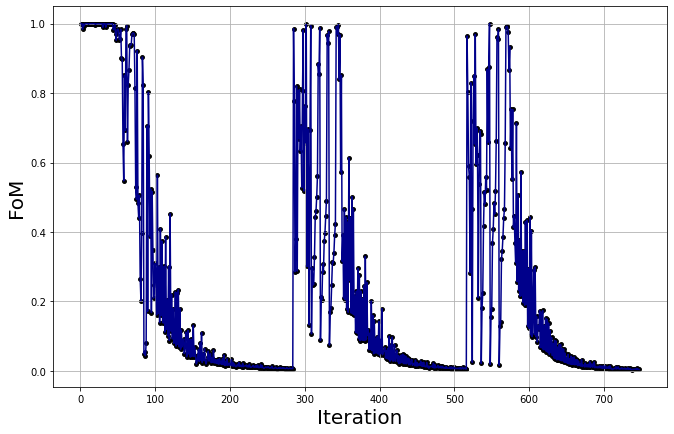

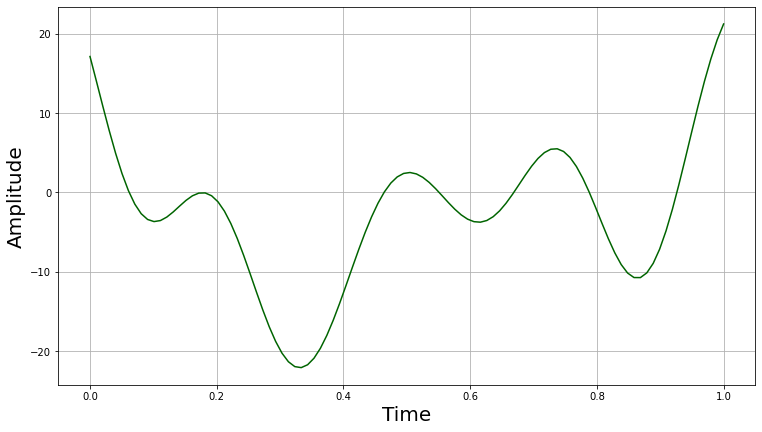

In [54]:
# FoM vs Iterations
fomlist = optimizer_obj.fom_list
fig = plt.figure(figsize=(11, 7))
ax = fig.add_subplot(111)
iterations = range(1, len(fomlist)+1)
ax.plot(iterations, 1 + np.asarray(fomlist), color='darkblue', linewidth=1.5, zorder=10)
ax.scatter(iterations, 1 + np.asarray(fomlist), color='k', s=15)
plt.grid(True, which="both")
plt.xlabel('Iteration', fontsize=20)
plt.ylabel('FoM', fontsize=20)
# Controls
controls = optimizer_obj.get_best_controls()
pulse, timegrid = controls[0][0], controls[1][0]
fig = plt.figure(figsize=(11, 7))
ax = fig.add_subplot(111)
plt.subplots_adjust(bottom=0.15, top=0.9, right=0.98, left=0.1)
plt.plot(timegrid, pulse, color='darkgreen', linewidth=1.5, zorder=10)
plt.grid(True, which="both")
plt.xlabel('Time', fontsize=20)
plt.ylabel('Amplitude', fontsize=20)

## GRAPE optimization

In [65]:
from IsingModel.AlastairProblem_GRAPE import AlastairFoMGRAPE

In [66]:
# Create the results path
results_path = "./results/"
if not os.path.exists(results_path):
    os.makedirs(results_path)

### Define the FoM class

In [67]:
args_dict = {"n_qubits": 5,
         "J": 1,
         "g": 2,
         "N_slices": 100,
         "T": 1.0}
fom = AlastairFoMGRAPE(args_dict)

Testing shaping option list mode
100


### Run the Optimization

In [68]:
t1 = time.time()

print("The optimizer started successfully")
fom.optimize()
print("The optimizer ran successfully")
thomas_stuff = fom.get_stuff_for_thomas()
print("The optimizer finished successfully")

t2 = time.time()
print("Optimization time: {optimization_time}"
      .format(optimization_time=t2 - t1))

The optimizer started successfully
The optimizer ran successfully
The optimizer finished successfully
Optimization time: 7.899299383163452


### Save the results

In [69]:
optimization_time = t2 -t1
with open(os.path.join(results_path, 'optimization_time.txt'), 'w') as f:
    f.write('# Time for optimization in seconds:\n')
    f.write(str(optimization_time))

fomlist = [element * (-1) for element in fom.GRAPE.fom_list]
np.savetxt(os.path.join(results_path, 'fom.txt'), fomlist)

np.savetxt(os.path.join(results_path, 'opt_pulses.txt'), fom.GRAPE.optimized_pulses)

### Plot the results

Text(0, 0.5, 'Amplitude')

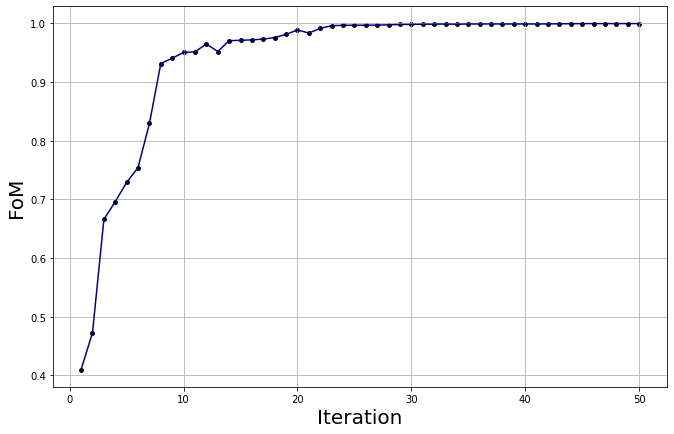

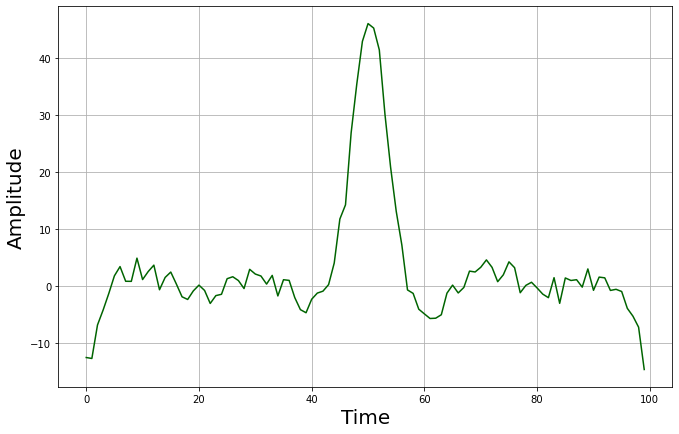

In [28]:
# FoM vs Iterations
fig = plt.figure(figsize=(11, 7))
ax = fig.add_subplot(111)
iterations = range(1, len(fomlist)+1)
ax.plot(iterations, 1 + np.asarray(fomlist), color='darkblue', linewidth=1.5, zorder=10)
ax.scatter(iterations, 1 + np.asarray(fomlist), color='k', s=15)
plt.grid(True, which="both")
plt.xlabel('Iteration', fontsize=20)
plt.ylabel('FoM', fontsize=20)
# Pulse
fig = plt.figure(figsize=(11, 7))
ax = fig.add_subplot(111)
ax.plot(fom.GRAPE.optimized_pulses, color='darkgreen', linewidth=1.5, zorder=10)
plt.grid(True, which="both")
plt.xlabel('Time', fontsize=20)
plt.ylabel('Amplitude', fontsize=20)

QuOCS version

In [64]:
import quocslib
quocslib.__VERSION__

'0.0.a7'